In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset

import numpy as np
import pickle 
import matplotlib.pyplot as plt

from load_CUB_and_CIFAR10 import *

In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

CPU


In [5]:
transform_CUB = transforms.Compose(
    [
        transforms.Resize((32,32)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

transform_CUB_test = transforms.Compose(
    [
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

transform = transforms.Compose(
    [
         transforms.ToTensor(),
     ]
)

# cub2011 = Cub2011_reduced('./',train=True,download=False,transform=transform_CUB,num_cat=10)
cub2011_basic_train = Cub2011_reduced('./',train=True,download=False,transform=transform_CUB,num_cat=10,just_bird=9)
cub2011_basic_test = Cub2011_reduced('./',train=False,download=False,transform=transform_CUB_test,num_cat=10,just_bird=9)

cifar10_nobird_train = CIFAR10_reduced(root='./data', remove_label=2, transform=transform, train=True)
# cifar10_nobird_test = CIFAR10_reduced(root='./data', remove_label=2, transform=transform, train=False)
cifar10_nobird_test = CIFAR10_reduced(root='./data', remove_label=2, transform=transform, train=False)

batch_size_train = 512 #64
batch_size_test = 200

combined_dataset_train = ConcatDataset([cifar10_nobird_train, cub2011_basic_train])
combined_dataset_test = ConcatDataset([cifar10_nobird_test, cub2011_basic_test])

# just bird
train_loader = DataLoader(combined_dataset_train, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(combined_dataset_test, batch_size=batch_size_test, shuffle=False)


cub2011_basic_train = Cub2011_reduced('./',train=True,download=False,transform=transform_CUB,num_cat=10)
cub2011_basic_test = Cub2011_reduced('./',train=False,download=False,transform=transform_CUB_test,num_cat=10)

combined_dataset_train2 = ConcatDataset([cifar10_nobird_train, cub2011_basic_train])
combined_dataset_test2 = ConcatDataset([cifar10_nobird_test, cub2011_basic_test])

# bird-subordinate
train_loader2 = DataLoader(combined_dataset_train2, batch_size=batch_size_train, shuffle=True)
test_loader2 = DataLoader(combined_dataset_test2, batch_size=batch_size_test, shuffle=False)


cub2011_basic_train = Cub2011_reduced('./',train=True,download=False,transform=transform_CUB,num_cat=10,idx_shift=0)
cub2011_basic_test = Cub2011_reduced('./',train=False,download=False,transform=transform_CUB_test,num_cat=10,idx_shift=0)

# birds only
train_loader3 = DataLoader(cub2011_basic_train, batch_size=batch_size_train, shuffle=True)
test_loader3 = DataLoader(cub2011_basic_test, batch_size=batch_size_test, shuffle=False)

# for basic
classes_combined = ('plane', 'car', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck','bird')

# for subordinate
classes_combined2 = ('plane', 'car', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck', \
                    'Black_footed_Albatross', 'Laysan_Albatross', 'Sooty_Albatross', 'Groove_billed_Ani','Crested_Auklet', \
                    'Least_Auklet', 'Parakeet_Auklet', 'Rhinoceros_Auklet', 'Brewer_Blackbird', 'Red_winged_Blackbird')

classes_birds  = ('Black_footed_Albatross', 'Laysan_Albatross', 'Sooty_Albatross', 'Groove_billed_Ani','Crested_Auklet', \
                    'Least_Auklet', 'Parakeet_Auklet', 'Rhinoceros_Auklet', 'Brewer_Blackbird', 'Red_winged_Blackbird')

all images will be treated as in the same category
idx shift:  9
all images will be treated as in the same category
idx shift:  9
Files already downloaded and verified
Files already downloaded and verified
idx shift:  9
idx shift:  9
idx shift:  0
idx shift:  0


In [6]:
class VAE_short(nn.Module):
    def __init__(self, latent_dim, img_size):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
#            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
#            nn.BatchNorm2d(64),
#            nn.ReLU(),
#            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
#            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * (img_size // 4) * (img_size // 4), 256),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * (img_size // 4) * (img_size // 4)),
            nn.ReLU(),
            nn.Unflatten(1, (64, img_size // 4, img_size // 4)),
#            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
#            nn.BatchNorm2d(64),
#            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
 #           nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            #nn.Sigmoid() # paper used sigmoid function at last
        )

    def reparameterize_sampling(self, mu, logvar):
        std = logvar.exp().sqrt()
        eps = torch.randn_like(mu).to(device)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize_sampling(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar

    def decode(self, z):
      return self.decoder(z)

class VAE(nn.Module):
    def __init__(self, latent_dim, img_size):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), 256),
            nn.LeakyReLU(),
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128 * (img_size // 8) * (img_size // 8)),
            nn.LeakyReLU(),
            nn.Unflatten(1, (128, img_size // 8, img_size // 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            #nn.Sigmoid() # paper used sigmoid function at last
        )

    def reparameterize_sampling(self, mu, logvar):
        std = logvar.exp().sqrt()
        eps = torch.randn_like(mu).to(device)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize_sampling(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar

    def decode(self, z):
      return self.decoder(z)

class SupervisedVAE(nn.Module):
    def __init__(self, latent_dim, img_size, num_classes):
        super(SupervisedVAE, self).__init__()
        self.vae = VAE(latent_dim, img_size)
        self.classifier = nn.Linear(latent_dim, num_classes)
        # self.classifier = nn.Sequential(
        #     # nn.Linear(latent_dim, 256),
        #     # nn.LeakyReLU(),
        #     nn.Linear(latent_dim, num_classes)
        #     #nn.Softmax() ?
        # )

    def forward(self, x):
        x_reconstructed, mu, logvar = self.vae(x)
        class_logits = self.classifier(mu)
        return x_reconstructed, mu, logvar, class_logits
    
class SupervisedVAE_basic(nn.Module):
    def __init__(self, latent_dim, img_size, num_classes, VAE_instance):
        super(SupervisedVAE_basic, self).__init__()
        # assumed that the architecture of VAE is already determined
        self.vae = VAE_instance
        self.classifier = nn.Linear(latent_dim, num_classes)
    
    def forward(self, x):
        x_reconstructed, mu, logvar = self.vae(x)
        class_logits = self.classifier(mu)
        return x_reconstructed, mu, logvar, class_logits

class SupervisedVAE_basic_relu(nn.Module):
    def __init__(self, latent_dim, img_size, num_classes, VAE_instance):
        super(SupervisedVAE_basic_relu, self).__init__()
        # assumed that the architecture of VAE is already determined
        self.vae = VAE_instance
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        ) # re-define
    
    def forward(self, x):
        x_reconstructed, mu, logvar = self.vae(x)
        class_logits = self.classifier(mu)
        return x_reconstructed, mu, logvar, class_logits

class SupervisedVAE_basic_re(nn.Module):
    # took off the classification layer, and then attach the new one

    def __init__(self, latent_dim, img_size, num_classes, SVAE_instance):
        super(SupervisedVAE_basic_re, self).__init__()
        # assumed that the architecture of VAE is already determined
        self.vae = SVAE_instance.vae
        self.classifier = nn.Linear(latent_dim, num_classes) # re-define
    
    def forward(self, x):
        x_reconstructed, mu, logvar = self.vae(x)
        class_logits = self.classifier(mu)
        return x_reconstructed, mu, logvar, class_logits

class SupervisedVAE_basic_re_relu(nn.Module):
    # took off the classification layer, and then attach the new one

    def __init__(self, latent_dim, img_size, num_classes, SVAE_instance):
        super(SupervisedVAE_basic_re_relu, self).__init__()
        # assumed that the architecture of VAE is already determined
        self.vae = SVAE_instance.vae
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        ) # re-define
    
    def forward(self, x):
        x_reconstructed, mu, logvar = self.vae(x)
        class_logits = self.classifier(mu)
        return x_reconstructed, mu, logvar, class_logits

# define loss functions
def KL_divergence(z_mu, z_log_sigma_sq):
  term_1 = z_log_sigma_sq.sum(axis=1) # trace log Sigma q
  term_2 = z_log_sigma_sq.exp().sum(axis=1) # trace Sigma q
  term_3 = (z_mu*z_mu).sum(axis=1) # this is mu_q squared and summed
  return 0.5*(-term_1 + term_2 + term_3 - z_mu.shape[1]).mean()

# def kl_divergence_2(mu, logvar):
#     kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return kld_loss

MSELoss = torch.nn.MSELoss(reduction='sum')

In [7]:
# some parameters for the model
# latent_dim = 128
lr = 3e-4
# lr2 = 0.00005
# num_epochs = 200
# beta = 1 #2
# gamma = 1 #1.5

num_cat = 10
num_cat2 = 19
img_size= 32

latent_dim = 128


# define network ----------------------------------------------
# VAE_instance = VAE(latent_dim128,img_size).to(device)
# VAE_instance.load_state_dict(torch.load('vae_cifar-10_sum_dim128_final.pth',map_location=device))

VAE_instance = VAE(latent_dim, img_size).to(device)
# VAE_instance.load_state_dict(torch.load('vae_cifar-10_sum_dim128_final.pth',map_location=device))
SVAE = SupervisedVAE_basic(latent_dim, img_size, num_cat, VAE_instance).to(device)
SVAE.load_state_dict(torch.load('svae_expertise_dim128_basic.pth',map_location=device))


SVAE2 = SupervisedVAE_basic_re_relu(latent_dim, img_size, num_cat2, SVAE).to(device)
SVAE2.load_state_dict(torch.load('svae_expertise_dim128_cifar-9_aug_relu.pth',map_location=device))

SVAE3 = SupervisedVAE_basic_re_relu(latent_dim, img_size, num_cat, SVAE).to(device)
SVAE3.load_state_dict(torch.load('svae_expertise_dim128_onlybirds_aug_relu.pth',map_location=device))


# # weight updating: from prev experiment
# folder='./saved_params_svae_cifar-10_dim128_gamma1_basic_c10/'
# SVAE.load_state_dict(torch.load(folder+'45.pth',map_location=device))

# # modify architecture here is required
# SVAE = SupervisedVAE_basic_re(latent_dim, img_size, num_cat, SVAE).to(device)

<All keys matched successfully>

In [9]:
# load save train/test losses

# --- VAE training ---
with open('svae_expertise_basic_losses_train.pkl','rb') as fp:
    losses_train = pickle.load(fp)

with open('svae_expertise_basic_losses_test.pkl','rb') as fp:
    losses_test = pickle.load(fp)


with open('svae_expertise_cifar-9_aug_relu_losses_train.pkl','rb') as fp:
    losses_train2 = pickle.load(fp)

with open('svae_expertise_cifar-9_aug_relu_losses_test.pkl','rb') as fp:
    losses_test2 = pickle.load(fp)

with open('svae_expertise_onlybirds_aug_relu_losses_train.pkl','rb') as fp:
    losses_train3 = pickle.load(fp)

with open('svae_expertise_onlybirds_aug_relu_losses_test.pkl','rb') as fp:
    losses_test3 = pickle.load(fp)

In [10]:
def plot_losses(losses_train,losses_test,supt='train/test loss',figsize=(8,8),is_svae=True):

    if is_svae:
        fig, axs = plt.subplots(2,2,figsize=figsize)

        axs[0,0].plot(losses_train['total'],label='train total loss')
        axs[0,0].plot(losses_test['total'],label='test total loss')
        axs[0,0].set_title('total loss')

        axs[0,1].plot(losses_train['mse'],label='train')
        axs[0,1].plot(losses_test['mse'],label='test')
        axs[0,1].set_title('MSE loss')

        axs[1,0].plot(losses_train['KLD'],label='train')
        axs[1,0].plot(losses_test['KLD'],label='test')
        axs[1,0].set_title('KL loss')

        axs[1,1].plot(losses_train['class'],label='train')
        axs[1,1].plot(losses_test['class'],label='test')
        axs[1,1].set_title('class loss')

        plt.suptitle(supt)

        
        for i in range(2):
            for j in range(2):
                axs[i,j].set_xlabel('Epoch')
                axs[i,j].set_ylabel('Total Loss')
        axs[1,1].legend(bbox_to_anchor=(1,-0.3))
        plt.tight_layout()
        plt.show()

    else:
        fig, axs = plt.subplots(1,3,figsize=figsize)
        axs[0].plot(losses_train['total'],label='train total loss')
        axs[0].plot(losses_test['total'],label='test total loss')
        axs[0].set_title('total loss')

        axs[1].plot(losses_train['mse'],label='train')
        axs[1].plot(losses_test['mse'],label='test')
        axs[1].set_title('MSE loss')

        axs[2].plot(losses_train['KLD'],label='train')
        axs[2].plot(losses_test['KLD'],label='test')
        axs[2].set_title('KL loss')
    
        plt.suptitle(supt)

        for i in range(3):
            axs[i].set_xlabel('Epoch')
            axs[i].set_ylabel('Total Loss')
        axs[2].legend(bbox_to_anchor=(1,-0.3))
        plt.tight_layout()
        plt.show()

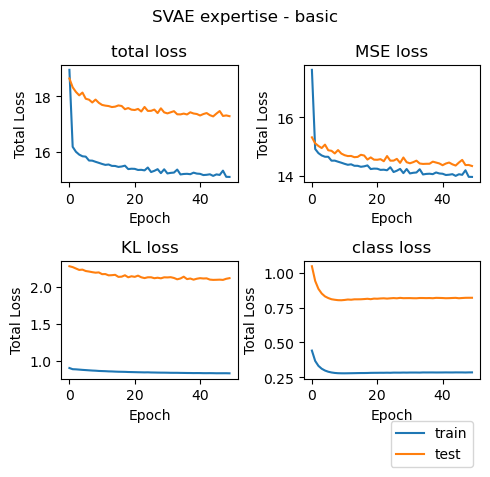

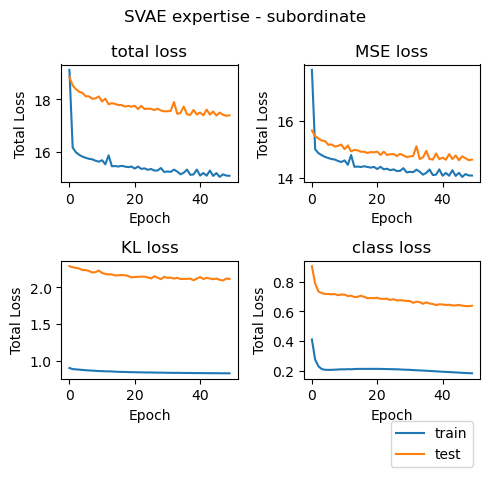

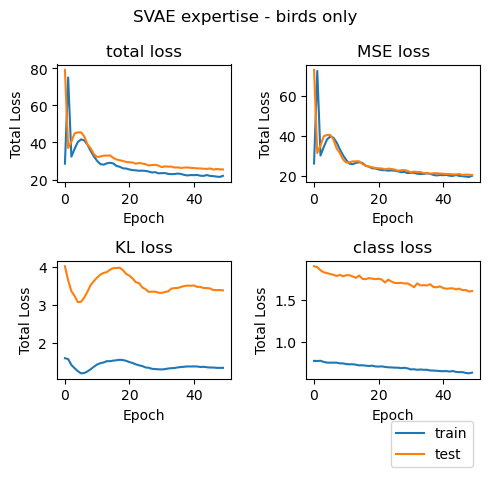

In [12]:
fs = (5,5)

plot_losses(losses_train,losses_test,'SVAE expertise - basic',figsize=fs,is_svae=True)

plot_losses(losses_train2,losses_test2,'SVAE expertise - subordinate',figsize=fs,is_svae=True)

plot_losses(losses_train3,losses_test3,'SVAE expertise - birds only',figsize=fs,is_svae=True)


visualized latent sapce

In [20]:
import umap 
from sklearn.decomposition import PCA 
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

def encode_dataset(model, dataloader):
    encoded_data = []
    labels = []
    with torch.no_grad():
        for x, label in dataloader:
            x = x.to(device)
            # label = nn.functional.one_hot(label,num_classes=num_cat).float()
            label = label.to(device)
            mu = model.forward(x)[1]
            encoded_data.append(mu.cpu().numpy())
            labels.append(label.cpu().numpy())
    encoded_data = np.concatenate(encoded_data)
    labels = np.concatenate(labels)

    # labels = np.argmax(labels,axis=1)

    return encoded_data, labels

def encode_dataset2(model, dataloader, do_aggregate=None):
    encoded_data = []
    labels = []
    if do_aggregate is not None:
        labels_agg = [] # labels larger than 9 would be just 9 (treat as birds)
    with torch.no_grad():
        for x, label in dataloader:
            x = x.to(device)
            # label = nn.functional.one_hot(label,num_classes=num_cat).float()
            label = label.to(device)
            mu = model.forward(x)[1]
            encoded_data.append(mu.cpu().numpy())
            label[label>=do_aggregate] = do_aggregate 
            labels.append(label.cpu().numpy())
    encoded_data = np.concatenate(encoded_data)
    labels = np.concatenate(labels)

    # labels = np.argmax(labels,axis=1)

    return encoded_data, labels

# Uniform Manifold Approximation and Projection (UMAP). UMAP is particularly well-suited for preserving both local and global structure in the data.
reducer_umap = umap.UMAP(n_components=2)
reducer_pca = PCA(n_components=2)
reducer_mds = MDS(n_components=2)
reducer_tsne = TSNE(n_components=2)

In [22]:
# do encoding first! (cifar-9 + bird basic)
# encoded_data, labels = encode_dataset(SVAE, train_loader)
encoded_data_val, labels_val = encode_dataset(SVAE, test_loader)
print('a')
# cifar-9 + bird basic -> but also check subordinate representations
# encoded_data, labels = encode_dataset(SVAE, train_loader2)
encoded_data_sep_val, labels_sep_val = encode_dataset(SVAE, test_loader2)
print('b')
# cifar-9 + subordinate
# encoded_data2, labels2 = encode_dataset(SVAE2, train_loader2)
encoded_data2_val, labels2_val = encode_dataset(SVAE2, test_loader2) # its aggregation can be acheived during plotting
print('c')
# birds only
# encoded_data3, labels3 = encode_dataset(SVAE3, train_loader3)
encoded_data3_val, labels3_val = encode_dataset(SVAE3, test_loader3)
encoded_data3_all_val, labels3_all_val = encode_dataset(SVAE3, test_loader2) # store all, and then aggregation can be done.
print('d')

a
b
c
d


In [23]:
# dimensionality reduction!
latent_tsne = reducer_tsne.fit_transform(encoded_data_val)
latent_pca = reducer_pca.fit_transform(encoded_data_val)
print('a')

latent_sep_tsne = reducer_tsne.fit_transform(encoded_data_sep_val)
latent_sep_pca = reducer_pca.fit_transform(encoded_data_sep_val)
print('b')

latent2_tsne = reducer_tsne.fit_transform(encoded_data2_val)
latent2_pca = reducer_pca.fit_transform(encoded_data2_val)
print('c')

latent3_tsne = reducer_tsne.fit_transform(encoded_data3_val)
latent3_pca = reducer_pca.fit_transform(encoded_data3_val)
print('d')

latent3_all_tsne = reducer_tsne.fit_transform(encoded_data3_all_val)
latent3_all_pca = reducer_pca.fit_transform(encoded_data3_all_val)
print('e')

a
b
c
d
e


In [33]:
# compute the clustering indices!

# calinski_harabasz_idx = calinski_harabasz_score(encoded_data, labels)
# print(f"Calinski-Harabasz Index: {calinski_harabasz_idx}")

chi_base = 85

# bird-basic
chi_birdbasic = calinski_harabasz_score(encoded_data_val, labels_val)

# bird-basic test on bird-sub
chi_birdbasic_on_subordinate = calinski_harabasz_score(encoded_data_sep_val, labels_sep_val)

# bird-sub
chi_subordinate = calinski_harabasz_score(encoded_data2_val, labels2_val)

# bird-sub test on bird-basic! aggregated!!!
labels2_val_agg = labels2_val.copy()
for i, val in enumerate(labels2_val_agg):
    if val >=9:
        labels2_val_agg[i] = 9

chi_subordinate_on_birdbasic = calinski_harabasz_score(encoded_data2_val, labels2_val_agg)

# bird-only
chi_birdonly = calinski_harabasz_score(encoded_data3_val, labels3_val)

# bird-only test on bird-sub
chi_birdonly_on_subordinate = calinski_harabasz_score(encoded_data3_all_val, labels3_all_val)

print('chi values: ')
print(f'base: {chi_base:.4f}, bird-basic: {chi_birdbasic:.4f}, bird-subordinate: {chi_subordinate:.4f}, bird-only: {chi_birdonly:.4f}')
print(f'bird-basic_on_subordinate: {chi_birdbasic_on_subordinate:.4f}, \
      bird-subordinate_on_birdbasic: {chi_subordinate_on_birdbasic:.4f}, bird-only_on_subordinate: {chi_birdonly_on_subordinate:.4f}')

chi values: 
base: 85.0000, bird-basic: 76.9615, bird-subordinate: 39.2033, bird-only: 2.1795
bird-basic_on_subordinate: 39.6381,       bird-subordinate_on_birdbasic: 76.3506, bird-only_on_subordinate: 39.0562


Let's also plot the train image set!

In [109]:
import seaborn as sns

def plot_latent(latent,labels,title='latent representation',average=False,figsize=(5,5),alpha=0.6,xlim=None,ylim=None):

    cvals = sns.color_palette("husl",10)
    # tlabels_cval = [cvals[x] for x in labels]

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    plt.figure(figsize=figsize)

    if not average:
        for i, val in enumerate(np.unique(labels)):
            this_idx = (labels == val)
            plt.scatter(latent[this_idx, 0], latent[this_idx, 1], color=cvals[i],alpha=alpha, label=classes[i])#, cmap='set1', s=5)

        plt.legend(bbox_to_anchor=(1,1))

    else:
        for i, val in enumerate(np.unique(labels)):
            this_idx = (labels == val)
            this_mean = latent[this_idx,].mean(axis=0)
            this_sd = latent[this_idx,].std(axis=0)

            plt.plot(this_mean[0],this_mean[1],'o',color=cvals[i], label=classes[i],alpha=alpha)
            plt.errorbar(this_mean[0],this_mean[1],yerr=this_sd[1],xerr=this_sd[0],color=cvals[i])
    
            plt.legend(bbox_to_anchor=(1.3,1))
    plt.title(title)

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.show()

def plot_latent2(latent,labels,title='latent representation',average=False,figsize=(5,5),alpha=0.6,xlim=None,ylim=None,xlim2=None,ylim2=None,s=5,s2=8):

    cvals = sns.color_palette("husl",10)
    # tlabels_cval = [cvals[x] for x in labels]

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    fig,axs = plt.subplots(1,2,figsize=figsize)


    for i, val in enumerate(np.unique(labels)):
        this_idx = (labels == val)
        axs[0].scatter(latent[this_idx, 0], latent[this_idx, 1], color=cvals[i],alpha=alpha, label=classes[i],s=s)#, cmap='set1', s=5)

    for i, val in enumerate(np.unique(labels)):
        this_idx = (labels == val)
        this_mean = latent[this_idx,].mean(axis=0)
        this_sd = latent[this_idx,].std(axis=0)

        axs[1].errorbar(this_mean[0],this_mean[1],yerr=this_sd[1],xerr=this_sd[0],color=cvals[i])
        axs[1].plot(this_mean[0],this_mean[1],'o',color=cvals[i], label=classes[i],alpha=alpha,markersize=s2)

    axs[1].legend(bbox_to_anchor=(1.3,1))

    plt.suptitle(title)

    if xlim is not None:
        axs[0].set_xlim(xlim)
    if ylim is not None:
        axs[0].set_ylim(ylim)

    if xlim2 is not None:
        axs[1].set_xlim(xlim)
    if ylim2 is not None:
        axs[1].set_ylim(ylim)
        
    plt.tight_layout()
    plt.show()

def plot_latent3(latent,labels,title='latent representation',average=False,figsize=(5,5),alpha=0.6,xlim=None,ylim=None,xlim2=None,ylim2=None,s=5,s2=8,basic=0,bb_anc=None):

    # tlabels_cval = [cvals[x] for x in labels]
    cm_cool = [plt.cm.cool(x) for x in np.linspace(0.1,0.9,4)]
    cm_hot = [plt.cm.autumn(x) for x in np.linspace(0.1,0.9,6)]
    # cm_cool = [plt.cm.Accent(x) for x in np.linspace(0.1,0.9,4)]
    # cm_hot = [plt.cm.Pastel2(x) for x in np.linspace(0.1,0.9,6)]
    cm_birds = [plt.cm.tab10(x) for x in np.linspace(0,.8,10)]

    if basic==0:
        classes = ('plane', 'car', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'bird')
        cvals = [cm_cool[0],cm_cool[1],cm_hot[0],cm_hot[1],cm_hot[2],cm_hot[3],cm_hot[4],cm_cool[2],cm_cool[3],cm_birds[0]]

    elif basic==1:
        classes = ('plane', 'car', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck', \
                        'Black_footed_Albatross', 'Laysan_Albatross', 'Sooty_Albatross', 'Groove_billed_Ani','Crested_Auklet', \
                        'Least_Auklet', 'Parakeet_Auklet', 'Rhinoceros_Auklet', 'Brewer_Blackbird', 'Red_winged_Blackbird')
        
        cvals = [cm_cool[0],cm_cool[1],cm_hot[0],cm_hot[1],cm_hot[2],cm_hot[3],cm_hot[4],cm_cool[2],cm_cool[3],\
                 cm_birds[0],cm_birds[1],cm_birds[2],cm_birds[3],cm_birds[4],cm_birds[5],cm_birds[6],cm_birds[7],\
                 cm_birds[8],cm_birds[9]]
    else:
        classes = ('Black_footed_Albatross', 'Laysan_Albatross', 'Sooty_Albatross', 'Groove_billed_Ani','Crested_Auklet', \
                        'Least_Auklet', 'Parakeet_Auklet', 'Rhinoceros_Auklet', 'Brewer_Blackbird', 'Red_winged_Blackbird')
        
        cvals = cm_birds

    # cvals = sns.color_palette("husl",len(classes))


    if average:

        fig,axs = plt.subplots(1,2,figsize=figsize)

        print(np.unique(labels))

        for i, val in enumerate(np.unique(labels)):
            this_idx = (labels == val)

            if (basic==0|basic==1) & (val>8):
                axs[0].scatter(latent[this_idx, 0], latent[this_idx, 1], color=cvals[i],marker='^',alpha=alpha, label=classes[i],s=s)
            else:
                axs[0].scatter(latent[this_idx, 0], latent[this_idx, 1], color=cvals[i],alpha=alpha, label=classes[i],s=s)

        for i, val in enumerate(np.unique(labels)):
            this_idx = (labels == val)
            this_mean = latent[this_idx,].mean(axis=0)
            this_sd = latent[this_idx,].std(axis=0)

            axs[1].errorbar(this_mean[0],this_mean[1],yerr=this_sd[1],xerr=this_sd[0],color=cvals[i],marker=None)

            if (basic==0|basic==1) & (val>8):
                axs[1].plot(this_mean[0],this_mean[1],'^',color=cvals[i], label=classes[i],alpha=alpha,markersize=s2)
            else:
                axs[1].plot(this_mean[0],this_mean[1],'o',color=cvals[i], label=classes[i],alpha=alpha,markersize=s2)

        if bb_anc is None:

            if basic==1:
                axs[1].legend(bbox_to_anchor=(1.68,1))
            else:
                axs[1].legend(bbox_to_anchor=(1.3,1))

        else:
            axs[1].legend(bbox_to_anchor=bb_anc)

        plt.suptitle(title)

        if xlim is not None:
            axs[0].set_xlim(xlim)
        if ylim is not None:
            axs[0].set_ylim(ylim)

        if xlim2 is not None:
            axs[1].set_xlim(xlim)
        if ylim2 is not None:
            axs[1].set_ylim(ylim)
            
        plt.tight_layout()
        plt.show()

    else:

        plt.figure(figsize=figsize)

        print(np.unique(labels))

        for i, val in enumerate(np.unique(labels)):
            this_idx = (labels == val)

            if (basic==0|basic==1) & (val>8):
                plt.scatter(latent[this_idx, 0], latent[this_idx, 1], color=cvals[i],marker='^',alpha=alpha, label=classes[i],s=s)
            else:
                plt.scatter(latent[this_idx, 0], latent[this_idx, 1], color=cvals[i],alpha=alpha, label=classes[i],s=s)


        if bb_anc is None:
            if basic==1:
                plt.legend(bbox_to_anchor=(1.68,1))
            else:
                plt.legend(bbox_to_anchor=(1.3,1))
        else:
            plt.legend(bbox_to_anchor=bb_anc)

        plt.suptitle(title)

        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        

        plt.tight_layout()
        plt.show()




[0 1 2 3 4 5 6 7 8 9]


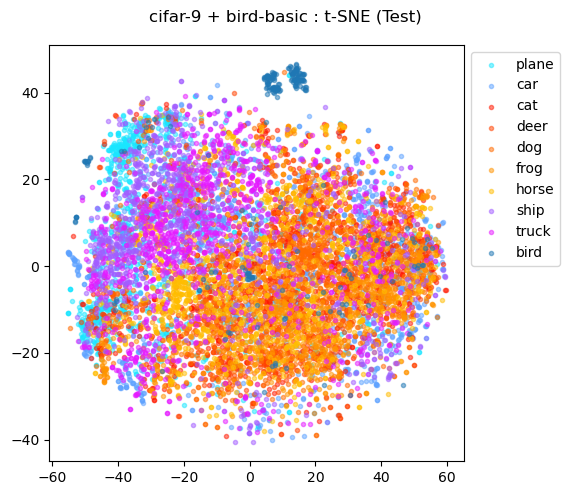

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


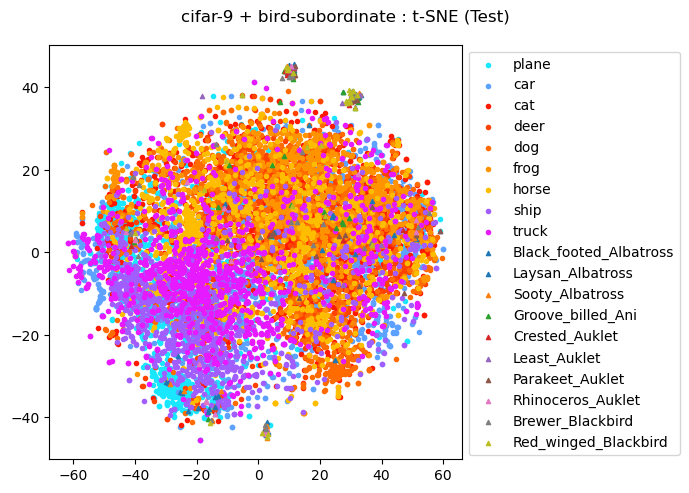

[ 9 10 11 12 13 14 15 16 17 18]


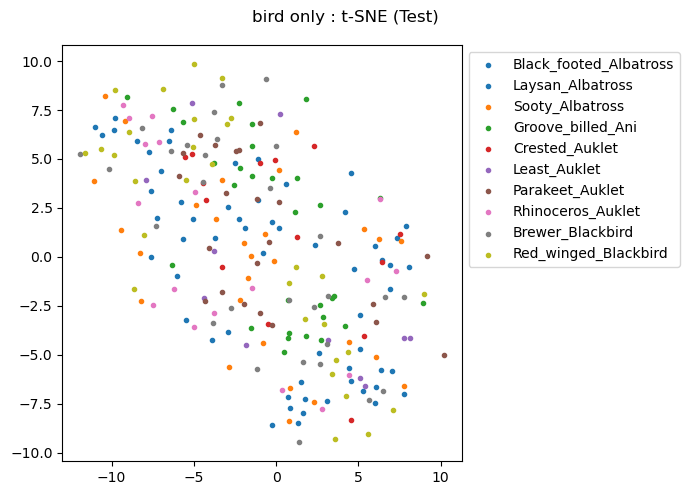

[0 1 2 3 4 5 6 7 8 9]


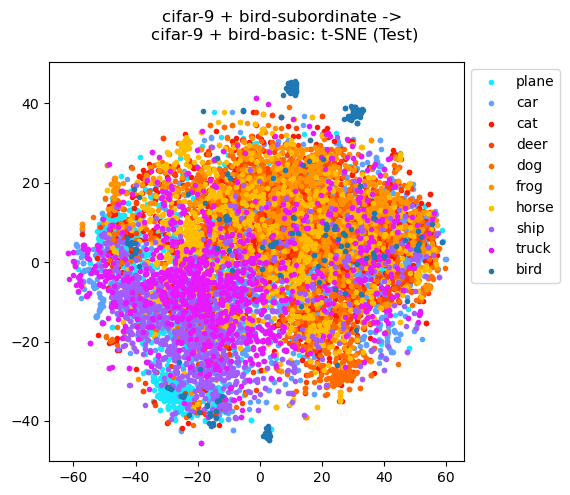

In [122]:
# # dimensionality reduction!
# latent_tsne = reducer_tsne.fit_transform(encoded_data_val)
# latent_pca = reducer_pca.fit_transform(encoded_data_val)
# print('a')

# latent_sep_tsne = reducer_tsne.fit_transform(encoded_data_sep_val)
# latent_sep_pca = reducer_pca.fit_transform(encoded_data_sep_val)
# print('b')

# latent2_tsne = reducer_tsne.fit_transform(encoded_data2_val)
# latent2_pca = reducer_pca.fit_transform(encoded_data2_val)
# print('c')

# latent3_tsne = reducer_tsne.fit_transform(encoded_data3_val)
# latent3_pca = reducer_pca.fit_transform(encoded_data3_val)
# print('d')

# latent3_all_tsne = reducer_tsne.fit_transform(encoded_data3_all_val)
# latent3_all_pca = reducer_pca.fit_transform(encoded_data3_all_val)
# print('e')


s= 5+4
s2 = 8+4

fs = (7,5)
bb_anc = (1,1)

avg=False

plot_latent3(latent_tsne,labels_val,title='cifar-9 + bird-basic : t-SNE (Test)',average=avg,figsize=(5.8,5),s=s,s2=s2,basic=0,alpha=.5,\
             bb_anc=bb_anc)
plot_latent3(latent2_tsne,labels2_val,title='cifar-9 + bird-subordinate : t-SNE (Test)',average=avg,figsize=fs,s=s,s2=s2,basic=1,alpha=1,\
             bb_anc=bb_anc)

plot_latent3(latent3_tsne,labels3_val,title='bird only : t-SNE (Test)',average=avg,figsize=fs,s=s,s2=s2,basic=2,alpha=1,\
             bb_anc=bb_anc)

plot_latent3(latent2_tsne,labels2_val_agg,title='cifar-9 + bird-subordinate -> \ncifar-9 + bird-basic: t-SNE (Test)',average=avg,figsize=(5.8,5),s=s,s2=s2,basic=0,alpha=1,\
             bb_anc=bb_anc)


Reconstruction

What's the distribution of images for this normalization?


In [134]:
def plot_recon(model,dataloader, dataloader2=None,img_n=36,nrow=6,figsize=(20,10),title='SVAE'):

    batch = next(iter(dataloader))

    images, labels = batch 

    images_ori = torchvision.utils.make_grid(images[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()

    if dataloader2 is None:

        fig, axs = plt.subplots(1,2,figsize=figsize)
        axs[0].imshow(images_ori); axs[0].set_title('original')

        recons, _, _, class_logits = model.forward(images.to(device))
        images_recon = torchvision.utils.make_grid(recons[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()
        axs[1].imshow(images_recon); axs[1].set_title('reconstructed')

        plt.suptitle(title)
        plt.axis('off')
        plt.tight_layout()

        plt.show()

    else:
        fig, axs = plt.subplots(2,2,figsize=figsize)
        axs[0,0].imshow(images_ori); axs[0,0].set_title('original, train set')

        recons, _, _, class_logits = model.forward(images.to(device))
        images_recon = torchvision.utils.make_grid(recons[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()
        axs[0,1].imshow(images_recon); axs[0,1].set_title('reconstructed, train set')


        batch = next(iter(dataloader2))
        images, labels = batch 
        images_ori = torchvision.utils.make_grid(images[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()

        axs[1,0].imshow(images_ori); axs[1,0].set_title('original, test set')
        recons, _, _, class_logits = model.forward(images.to(device))
        images_recon = torchvision.utils.make_grid(recons[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()
        axs[1,1].imshow(images_recon); axs[1,1].set_title('reconstructed, test set')

        plt.suptitle(title)
        for i in range(2):
            for j in range(2):
                axs[i,j].axis('off')

        plt.tight_layout()

        plt.show()

def plot_recon2(model,images1, images2=None,img_n=36,nrow=6,figsize=(20,10),title='SVAE', is_svae=True):

    # batch = next(iter(dataloader))

    # images, labels = batch 

    images_ori = torchvision.utils.make_grid(images1[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()

    if images2 is None:

        fig, axs = plt.subplots(1,2,figsize=figsize)
        axs[0].imshow(images_ori); axs[0].set_title('original')

        if is_svae:
            recons, _, _, class_logits = model.forward(images1.to(device))
        else:
            recons, _, _ = model.forward(images1.to(device))
        images_recon = torchvision.utils.make_grid(recons[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()
        axs[1].imshow(images_recon); axs[1].set_title('reconstructed')

        plt.suptitle(title)
        plt.axis('off')
        plt.tight_layout()

        plt.show()

    else:
        fig, axs = plt.subplots(2,2,figsize=figsize)
        axs[0,0].imshow(images_ori); axs[0,0].set_title('original, train set')

        if is_svae:
            recons, _, _, class_logits = model.forward(images1.to(device))
        else:
            recons, _, _ = model.forward(images1.to(device))
        images_recon = torchvision.utils.make_grid(recons[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()
        axs[0,1].imshow(images_recon); axs[0,1].set_title('reconstructed, train set')

        images_ori = torchvision.utils.make_grid(images2[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()

        axs[1,0].imshow(images_ori); axs[1,0].set_title('original, test set')
        if is_svae:
            recons, _, _, class_logits = model.forward(images2.to(device))
        else:
            recons, _, _ = model.forward(images2.to(device))
        images_recon = torchvision.utils.make_grid(recons[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()
        axs[1,1].imshow(images_recon); axs[1,1].set_title('reconstructed, test set')

        plt.suptitle(title)
        for i in range(2):
            for j in range(2):
                axs[i,j].axis('off')

        plt.tight_layout()

        plt.show()

def plot_recon3(model,images1,img_n=36,nrow=6,figsize=(20,10),title='SVAE', is_svae=True):

    # batch = next(iter(dataloader))

    # images, labels = batch 

    images_ori = torchvision.utils.make_grid(images1[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()


    fig, axs = plt.subplots(1,2,figsize=figsize)
    axs[0].imshow(images_ori); axs[0].set_title('original')

    if is_svae:
        recons, _, _, class_logits = model.forward(images1.to(device))
    else:
        recons, _, _ = model.forward(images1.to(device))
    images_recon = torchvision.utils.make_grid(recons[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()
    axs[1].imshow(images_recon); axs[1].set_title('reconstructed')

    plt.suptitle(title)
    plt.axis('off')
    plt.tight_layout()

    plt.suptitle(title)
    for i in range(2):
        axs[i].axis('off')

    plt.tight_layout()

    plt.show()

In [159]:
temp_test_loader2 = DataLoader(combined_dataset_test2, batch_size=len(combined_dataset_test2), shuffle=False)
images, lablab = next(iter(temp_test_loader2))

In [167]:
lablab[torch.argwhere(lablab==0)[0]]

tensor([0])

In [170]:
images[0,:,:,:].reshape((1,3,32,32)).shape

torch.Size([1, 3, 32, 32])

In [176]:
images.shape

torch.Size([9243, 3, 32, 32])

In [184]:
unique_idx = [torch.argwhere(lablab==x)[0].item() for x in torch.unique(lablab)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


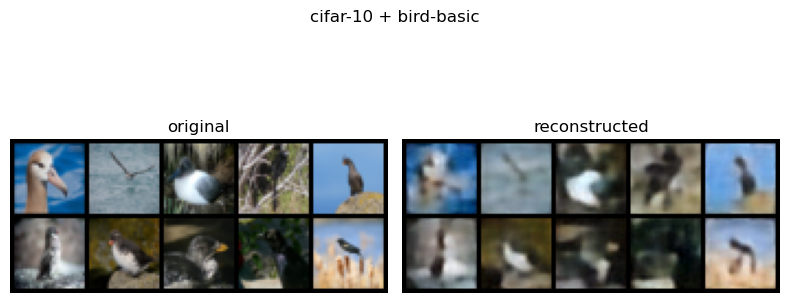

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


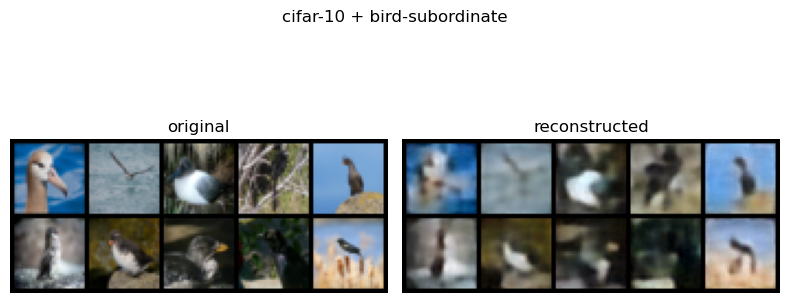

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


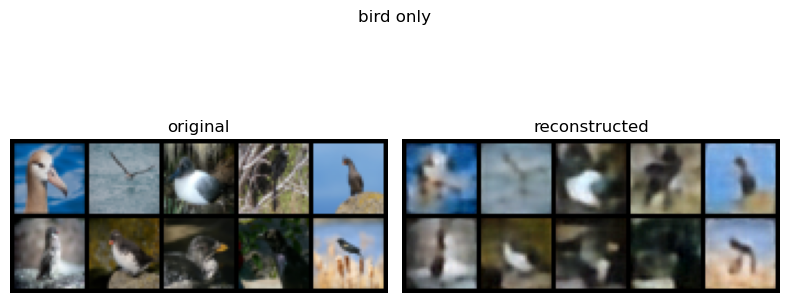

In [195]:

plot_recon3(SVAE, images[unique_idx[9:],:,:,:], nrow=5,title='cifar-10 + bird-basic',figsize=(8,4),is_svae=True)

plot_recon3(SVAE2, images[unique_idx[9:],:,:,:], nrow=5, title='cifar-10 + bird-subordinate',figsize=(8,4),is_svae=True)

plot_recon3(SVAE3, images[unique_idx[9:],:,:,:], nrow=5, title='bird only',figsize=(8,4),is_svae=True)



# # img,lab=next(iter(train_loader2))

# indices_cifar10 = labels2_val < 9

# for i in range(10):
#     axs[0,i].imshow()





# images_ori = torchvision.utils.make_grid(images1[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()


# fig, axs = plt.subplots(1,2,figsize=figsize)
# axs[0].imshow(images_ori); axs[0].set_title('original')

# if is_svae:
#     recons, _, _, class_logits = model.forward(images1.to(device))
# else:
#     recons, _, _ = model.forward(images1.to(device))
# images_recon = torchvision.utils.make_grid(recons[:img_n,:,:,:],nrow=nrow).cpu().permute(1,2,0).numpy()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


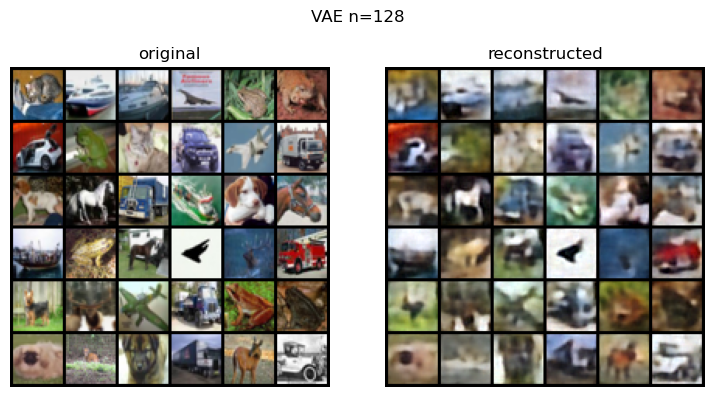

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


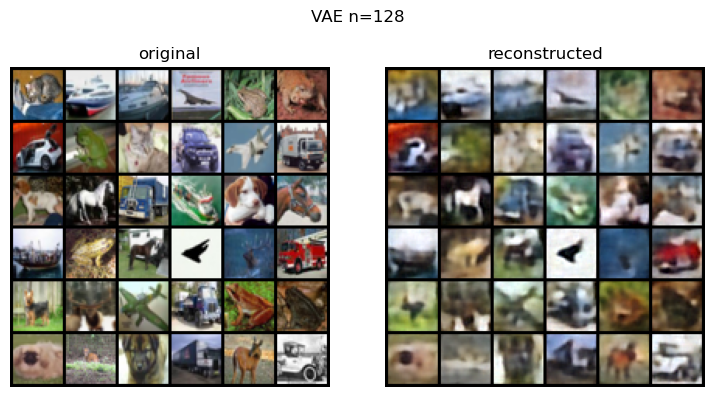

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


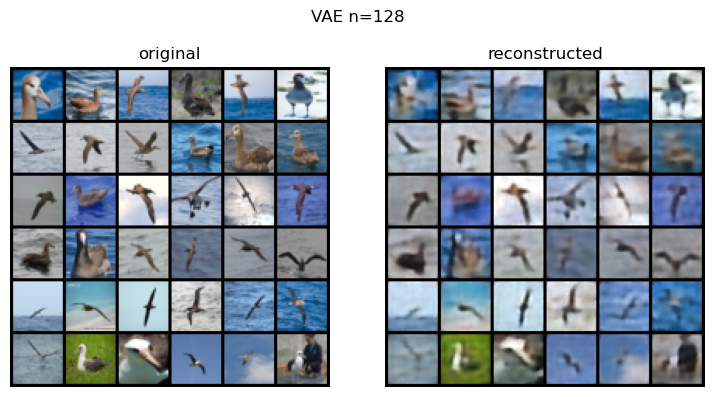

In [137]:
train_images,_ = next(iter(train_loader))
test_images,_ = next(iter(test_loader))

plot_recon3(SVAE, test_images, title='VAE n=128',figsize=(8,4),is_svae=True)

train_images,_ = next(iter(train_loader2))
test_images,_ = next(iter(test_loader2))

plot_recon3(SVAE2, test_images, title='VAE n=128',figsize=(8,4),is_svae=True)

train_images,_ = next(iter(train_loader3))
test_images,_ = next(iter(test_loader3))

plot_recon3(SVAE3, test_images, title='VAE n=128',figsize=(8,4),is_svae=True)

In [201]:
# just bird
train_loader = DataLoader(combined_dataset_train, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(combined_dataset_test, batch_size=batch_size_test, shuffle=False)

# bird-subordinate
train_loader2 = DataLoader(combined_dataset_train2, batch_size=batch_size_train, shuffle=True)
test_loader2 = DataLoader(combined_dataset_test2, batch_size=batch_size_test, shuffle=False)

# birds only
train_loader3 = DataLoader(cub2011_basic_train, batch_size=batch_size_train, shuffle=True)
test_loader3 = DataLoader(cub2011_basic_test, batch_size=batch_size_test, shuffle=False)

[[], [], [], [], []]

In [202]:
lablab

tensor([ 2,  7,  7,  ..., 18, 18, 18])

In [204]:
len(train_loader)

89

In [227]:
# for each model, compute the total average accuracy as well as the category-level accuracy, and then second-order accuracy
# train_accs = [[]]*10
# train_accs2 = [[]]*19
# train_accs3 = [[]]*0

train_accs = np.empty(len(train_loader))
test_accs = np.empty(len(test_loader))
for i, data in enumerate(train_loader,0):

    x, lab = data 

    x = x.to(device)
    lab = lab.to(device)

    _, _, _, class_logits = SVAE.forward(x)

    # actual_labels.append(lab.cpu().numpy())
    # pred_labels.append(torch.argmax(class_logits,dim=1).cpu().numpy() )
    train_accs[i]= np.mean(lab.cpu().numpy() == torch.argmax(class_logits,dim=1).cpu().numpy())

for i, data in enumerate(test_loader,0):
    
    x, lab = data
    
    x = x.to(device)
    lab = lab.to(device)

    _, _, _, class_logits = SVAE.forward(x)

    # actual_labels_test.append(lab.cpu().numpy())
    # pred_labels_test.append(torch.argmax(class_logits,dim=1).cpu().numpy() )
    test_accs[i]= np.mean(lab.cpu().numpy() == torch.argmax(class_logits,dim=1).cpu().numpy())
    # test_acc.append(np.mean(lab.cpu().numpy() == torch.argmax(class_logits,dim=1).cpu().numpy()))


train_accs2 = np.empty(len(train_loader2))
test_accs2 = np.empty(len(test_loader2))
for i, data in enumerate(train_loader2,0):

    x, lab = data 

    x = x.to(device)
    lab = lab.to(device)

    _, _, _, class_logits = SVAE2.forward(x)

    # actual_labels.append(lab.cpu().numpy())
    # pred_labels.append(torch.argmax(class_logits,dim=1).cpu().numpy() )
    train_accs2[i]= np.mean(lab.cpu().numpy() == torch.argmax(class_logits,dim=1).cpu().numpy())

for i, data in enumerate(test_loader2,0):
    
    x, lab = data
    
    x = x.to(device)
    lab = lab.to(device)

    _, _, _, class_logits = SVAE2.forward(x)

    # actual_labels_test.append(lab.cpu().numpy())
    # pred_labels_test.append(torch.argmax(class_logits,dim=1).cpu().numpy() )
    test_accs2[i]= np.mean(lab.cpu().numpy() == torch.argmax(class_logits,dim=1).cpu().numpy())
    # test_acc.append(np.mean(lab.cpu().numpy() == torch.argmax(class_logits,dim=1).cpu().numpy()))


train_accs3 = np.empty(len(train_loader3))
test_accs3 = np.empty(len(test_loader3))
for i, data in enumerate(train_loader3,0):

    x, lab = data 

    x = x.to(device)
    lab = lab.to(device)

    _, _, _, class_logits = SVAE3.forward(x)

    # actual_labels.append(lab.cpu().numpy())
    # pred_labels.append(torch.argmax(class_logits,dim=1).cpu().numpy() )
    train_accs3[i]= np.mean(lab.cpu().numpy() == torch.argmax(class_logits,dim=1).cpu().numpy())

for i, data in enumerate(test_loader3,0):
    
    x, lab = data
    
    x = x.to(device)
    lab = lab.to(device)

    _, _, _, class_logits = SVAE3.forward(x)

    # actual_labels_test.append(lab.cpu().numpy())
    # pred_labels_test.append(torch.argmax(class_logits,dim=1).cpu().numpy() )
    test_accs3[i]= np.mean(lab.cpu().numpy() == torch.argmax(class_logits,dim=1).cpu().numpy())
    # test_acc.append(np.mean(lab.cpu().numpy() == torch.argmax(class_logits,dim=1).cpu().numpy()))



(0.0, 1.0)

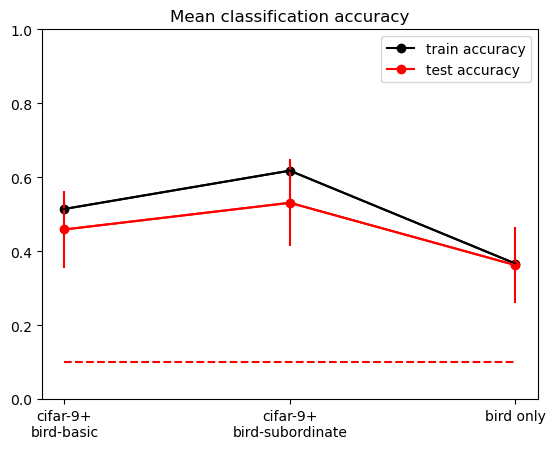

In [229]:
m_accs_train = np.mean(train_accs)
sd_accs_train = np.std(train_accs)
m_accs_test = np.mean(test_accs)
sd_accs_test = np.std(test_accs)

m_accs_train2 = np.mean(train_accs2)
sd_accs_train2 = np.std(train_accs2)
m_accs_test2 = np.mean(test_accs2)
sd_accs_test2 = np.std(test_accs2)

m_accs_train3 = np.mean(train_accs3)
sd_accs_train3 = np.std(train_accs3)
m_accs_test3 = np.mean(test_accs3)
sd_accs_test3 = np.std(test_accs3)

Ms = np.array([m_accs_train,m_accs_train2,m_accs_train3])
Ms2 = np.array([m_accs_test,m_accs_test2,m_accs_test3])

sds = np.array([sd_accs_train,sd_accs_train2,sd_accs_train3])
sds2 = np.array([sd_accs_test,sd_accs_test2,sd_accs_test3])

plt.plot(range(3),Ms,'o-',label='train accuracy',color='k')
plt.plot(range(3),Ms2,'o-',label='test accuracy',color='r')

plt.errorbar(range(3),Ms,sds,marker=None,linestyle=None,color='k')
plt.errorbar(range(3),Ms2,sds2,linestyle=None,marker=None,color='r')

plt.xticks(range(3),['cifar-9+\nbird-basic','cifar-9+\nbird-subordinate','bird only'])
# plt.xlabel('Epoch')
plt.title('Mean classification accuracy')
# plt.xticks(range(len(m_accs_train)),list_path); plt.xlabel('Epoch')

plt.legend()

plt.plot([0,2],np.ones(2)*0.1,'r--',label='chance level')
plt.ylim((0,1))
# for i in range(len(m_accs_train)):
#     plt.plot([1,2], [m_accs_train[i], m_accs_test[i]], 'o-', label=f'{list_path[i]+1}th epoch')
#     plt.errorbar([1,2], [m_accs_train[i], m_accs_test[i]], [sd_accs_train[i], sd_accs_test[i]], \
#                  linestyle='none')

# plt.xlim((1-.2,2+.2))
# plt.xticks([1,2],labels=['train','test'])
# plt.ylim((0,1.2))
# plt.plot([1-.2,2+.2],np.ones(2)*0.1,'r--',label='chance level')
# plt.text(1,0.12,'chance level',color='red')
# plt.title('Classification Accuracy')
# plt.ylabel('Mean classification accuracy')
# plt.legend(bbox_to_anchor=(1,1))
# plt.show()

In [8]:
# for each model, compute the total average accuracy as well as the category-level accuracy, and then second-order accuracy
# train_accs = [[]]*10
# train_accs2 = [[]]*19
# train_accs3 = [[]]*0

train_accs_cat = []
test_accs_cat = []
train_lab = []
test_lab = []
for i, data in enumerate(train_loader,0):

    x, lab = data 

    x = x.to(device)
    lab = lab.to(device)

    _, _, _, class_logits = SVAE.forward(x)


    train_lab.append(lab.cpu().numpy())
    train_accs_cat.append(torch.argmax(class_logits,dim=1).cpu().numpy() )
    # train_accs[i]= np.mean(lab.cpu().numpy() == torch.argmax(class_logits,dim=1).cpu().numpy())


for i, data in enumerate(test_loader,0):
    
    x, lab = data
    
    x = x.to(device)
    lab = lab.to(device)

    _, _, _, class_logits = SVAE.forward(x)

    test_lab.append(lab.cpu().numpy())
    test_accs_cat.append(torch.argmax(class_logits,dim=1).cpu().numpy() )
    # test_accs[i]= np.mean(lab.cpu().numpy() == torch.argmax(class_logits,dim=1).cpu().numpy())
    # test_acc.append(np.mean(lab.cpu().numpy() == torch.argmax(class_logits,dim=1).cpu().numpy()))


train_accs2_cat = []
test_accs2_cat = []

train_lab2 = []
test_lab2 = []

for i, data in enumerate(train_loader2,0):

    x, lab = data 

    x = x.to(device)
    lab = lab.to(device)

    _, _, _, class_logits = SVAE2.forward(x)

    train_lab2.append(lab.cpu().numpy())
    train_accs2_cat.append(torch.argmax(class_logits,dim=1).cpu().numpy() )


for i, data in enumerate(test_loader2,0):
    
    x, lab = data
    
    x = x.to(device)
    lab = lab.to(device)

    _, _, _, class_logits = SVAE2.forward(x)

    test_lab2.append(lab.cpu().numpy())
    test_accs2_cat.append(torch.argmax(class_logits,dim=1).cpu().numpy() )


train_accs3_cat = []
test_accs3_cat = []

train_lab3 = []
test_lab3 = []

for i, data in enumerate(train_loader3,0):

    x, lab = data 

    x = x.to(device)
    lab = lab.to(device)

    _, _, _, class_logits = SVAE3.forward(x)

    train_lab3.append(lab.cpu().numpy())
    train_accs3_cat.append(torch.argmax(class_logits,dim=1).cpu().numpy() )

for i, data in enumerate(test_loader3,0):
    
    x, lab = data
    
    x = x.to(device)
    lab = lab.to(device)

    _, _, _, class_logits = SVAE3.forward(x)

    test_lab3.append(lab.cpu().numpy())
    test_accs3_cat.append(torch.argmax(class_logits,dim=1).cpu().numpy() )

In [9]:
import itertools  

train_accs_cat = list(itertools.chain(*train_accs_cat))
test_accs_cat = list(itertools.chain(*test_accs_cat))
train_lab = list(itertools.chain(*train_lab))
test_lab = list(itertools.chain(*test_lab))

train_accs2_cat = list(itertools.chain(*train_accs2_cat))
test_accs2_cat = list(itertools.chain(*test_accs2_cat))
train_lab2 = list(itertools.chain(*train_lab2))
test_lab2 = list(itertools.chain(*test_lab2))

train_accs3_cat = list(itertools.chain(*train_accs3_cat))
test_accs3_cat = list(itertools.chain(*test_accs3_cat))
train_lab3 = list(itertools.chain(*train_lab3))
test_lab3 = list(itertools.chain(*test_lab3))

In [10]:
train_accs_cat = np.array(train_accs_cat)
test_accs_cat = np.array(test_accs_cat)
train_lab = np.array(train_lab)
test_lab = np.array(test_lab)

train_accs2_cat = np.array(train_accs2_cat)
test_accs2_cat = np.array(test_accs2_cat)
train_lab2 = np.array(train_lab2)
test_lab2 = np.array(test_lab2)

train_accs3_cat = np.array(train_accs3_cat)
test_accs3_cat = np.array(test_accs3_cat)
train_lab3 = np.array(train_lab3)
test_lab3 = np.array(test_lab3)

In [15]:
# aggregation

Accs = np.empty((2,10))
Accs2 = np.empty((2,19))
Accs3 = np.empty((2,10))

SDs = np.empty((2,10))
SDs2 = np.empty((2,19))
SDs3 = np.empty((2,10))

Accs22 = np.empty((2,19))
SDs22 = np.empty((2,19))

for i in range(10):

    this_indices = train_lab==i
    # for train (0)
    Accs[0,i] = (train_accs_cat[this_indices]==i).mean()
    SDs[0,i] = (train_accs_cat[this_indices]==i).std()


    this_indices2 = test_lab==i
    # for test (1)
    Accs[1,i] = (test_accs_cat[this_indices2]==i).mean()
    SDs[1,i] = (test_accs_cat[this_indices2]==i).std()

for i in range(19):

    this_indices = train_lab2==i
    # for train (0)
    Accs2[0,i] = (train_accs2_cat[this_indices]==i).mean()
    SDs2[0,i] = (train_accs2_cat[this_indices]==i).std()

    if i >= 9:
        Accs22[0,i] = (train_accs2_cat[this_indices]>=9).mean()
        SDs22[0,i] = (train_accs2_cat[this_indices]>=9).std()


    this_indices2 = test_lab2==i
    # for test (1)
    Accs2[1,i] = (test_accs2_cat[this_indices2]==i).mean()
    SDs2[1,i] = (test_accs2_cat[this_indices2]==i).std()


    if i >= 9:
        Accs22[1,i] = (test_accs2_cat[this_indices2]>=9).mean()
        SDs22[1,i] = (test_accs2_cat[this_indices2]>=9).std()


for i in range(10):

    this_indices = train_lab3==i
    # for train (0)
    Accs3[0,i] = (train_accs3_cat[this_indices]==i).mean()
    SDs3[0,i] = (train_accs3_cat[this_indices]==i).std()

    this_indices2 = test_lab3==i
    # for test (1)
    Accs3[1,i] = (test_accs3_cat[this_indices2]==i).mean()
    SDs3[1,i] = (test_accs3_cat[this_indices2]==i).std()    


In [21]:
test_accs3_cat[this_indices2]

array([1, 4, 0, 3, 9, 9, 7, 9, 9, 7, 3, 9, 9, 3, 9, 9, 9, 9, 3, 7, 9, 9,
       9, 9, 7, 9, 1, 9, 9, 9])

In [18]:
Accs22

array([[0.49400421, 0.34760846, 0.49995644, 0.47715788, 0.49030195,
        0.39909718, 0.46419647, 0.45074498, 0.45394696, 0.1       ,
        0.06666667, 0.06666667, 0.        , 0.        , 0.        ,
        0.06666667, 0.1       , 0.13333333, 0.16666667],
       [0.49847668, 0.41692206, 0.48706365, 0.45513844, 0.47911481,
        0.42889509, 0.48412292, 0.47820916, 0.48729457, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

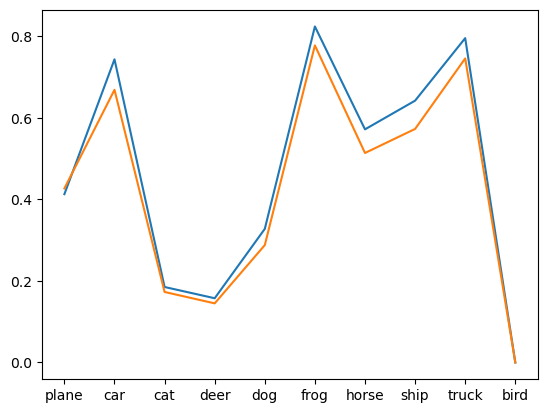

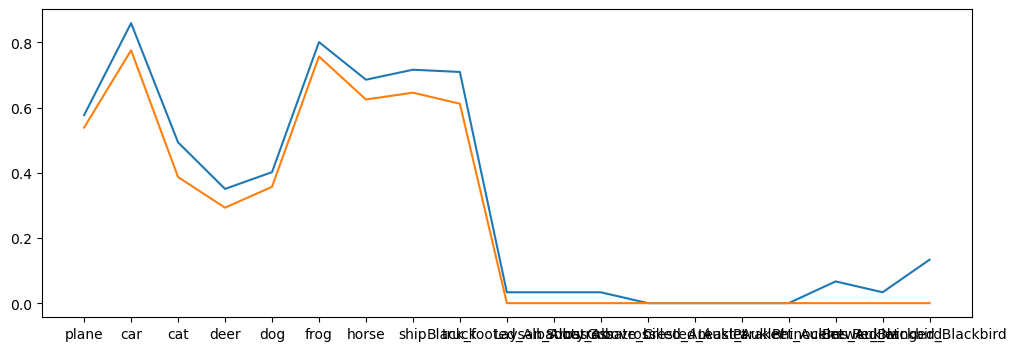

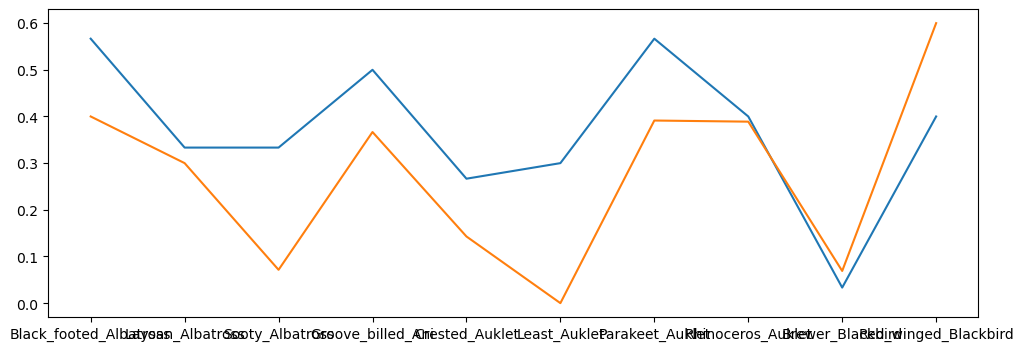

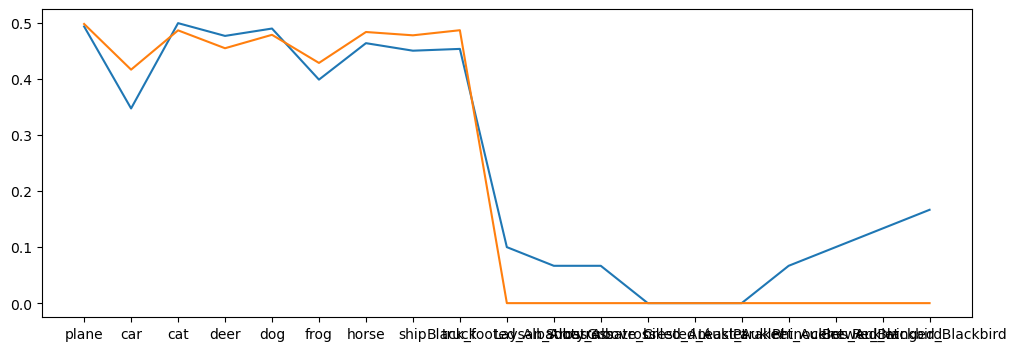

In [16]:
plt.plot(range(10),Accs[0,:],label='train')
plt.plot(range(10),Accs[1,:],label='test')
plt.xticks(range(10),classes_combined)
plt.show()
# plt.bar(Accs2[0,:])
# plt.bar(Accs3[0,:])
plt.figure(figsize=(12,4))
plt.plot(range(19),Accs2[0,:],label='train')
plt.plot(range(19),Accs2[1,:],label='test')
plt.xticks(range(19),classes_combined2)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(range(10),Accs3[0,:],label='train')
plt.plot(range(10),Accs3[1,:],label='test')
plt.xticks(range(10),classes_birds)
plt.show()

# plt.figure(figsize=(12,4))
# plt.plot(range(19),Accs22[0,:],label='train')
# plt.plot(range(19),Accs22[1,:],label='test')
# plt.xticks(range(19),classes_combined2)
# plt.show()

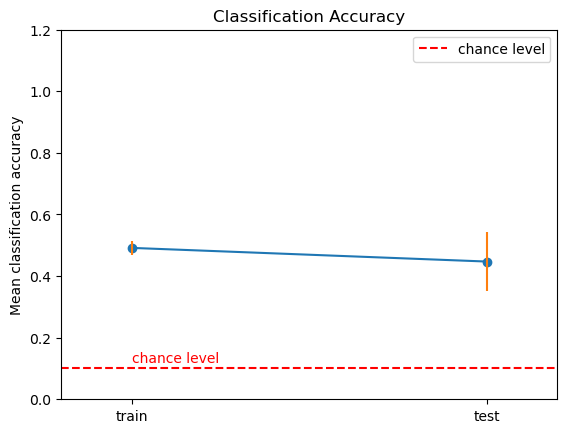

In [37]:
# print(f'train accuracy : {np.array(train_acc).mean()}')
# print(f'test accuracy : {np.array(test_acc).mean()}')

m_acc_train = np.mean(train_accs)
sd_acc_train = np.std(train_accs)
m_acc_test = np.mean(test_accs)
sd_acc_test = np.std(test_accs)

# m_accs = [np.array(train_acc).mean(),np.array(test_acc).mean()]
# sd_accs = [np.array(train_acc).std(),np.array(test_acc).std()]

# for i in range(len(m_accs_train)):
plt.plot([1,2], [m_acc_train, m_acc_test], 'o-')
plt.errorbar([1,2], [m_acc_train, m_acc_test], [sd_acc_train, sd_acc_test], \
                linestyle='none')

plt.xlim((1-.2,2+.2))
plt.xticks([1,2],labels=['train','test'])
plt.ylim((0,1.2))
plt.plot([1-.2,2+.2],np.ones(2)*0.1,'r--',label='chance level')
plt.text(1,0.12,'chance level',color='red')
plt.title('Classification Accuracy')
plt.ylabel('Mean classification accuracy')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

train accuracy : 0.5806625639386189
test accuracy : 0.5349


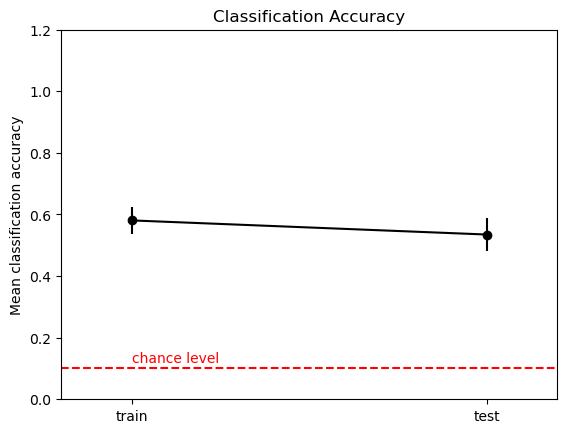

In [114]:
# print(f'train accuracy : {np.array(train_acc).mean()}')
# print(f'test accuracy : {np.array(test_acc).mean()}')

# m_acc = [np.array(train_acc).mean(),np.array(test_acc).mean()]
# sd_acc = [np.array(train_acc).std(),np.array(test_acc).std()]

# plt.plot( [1,2], m_acc, 'ko-')
# plt.errorbar([1,2], m_acc, sd_acc, color='black',linestyle='none')

# plt.xlim((1-.2,2+.2))
# plt.xticks([1,2],labels=['train','test'])
# plt.ylim((0,1.2))
# plt.plot([1-.2,2+.2],np.ones(2)*0.1,'r--',label='chance level')
# plt.text(1,0.12,'chance level',color='red')
# plt.title('Classification Accuracy')
# plt.ylabel('Mean classification accuracy')
# plt.show()